# Introduction
In the previous posts, we calculated accessibility in terms of distance. Distance is an excellent metric for driving or walking on flat land. For short travels by car or walking on flat land, distance can be directly converted to travel time; most people have an intuitive understanding of their average driving speeds (50 km/h for residential roads in New Zealand) or their approximate walking speed on flat land (usually around 5 km / h for a fit adult as given in [Section 3.4 in NZTA pedestrian planning and design guide](https://www.nzta.govt.nz/assets/resources/pedestrian-planning-guide/docs/pedestrian-planning-guide.pdf)). Hills are not an issue for drivers provided road quality and safety are no different to flat land. But hills do impact travel time significantly for pedestrians; which in turn impacts accessibility. 

> _This post will consider the impact of hills on pedestrian accessibility to playgrounds in Wellington._

Playgrounds are key amenities that impact the quality of life for young families. Since they are also frequently accessed on foot, it's important to consider how accessible they really are. Particularly for suburbs with a high residential fraction.   

## Tasks
- Calculate the impact of walking in hilly terrain on travel time to council playgrounds in Wellington
- Compare the travel times to playground for the largest residential suburbs in Wellington
- Model the average travel time to a playground by suburb 


## Technical details
To do this analysis, we need to overcome some technical aspects:
- Re-do accessibility analysis: from distance to travel time
- Get elevation data for roads and walkways
- Convert elevation to road / walkway inclination 
- Incorporate inclination in the accessibility analysis
    - Include road inclines in the pandana network
    - Estimate the impact of inclination on travel time
    


In [95]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.data_processing as dp
import utils.accessibility_analysis as aa
import utils.util as u
import geopandas 
import numpy as np
import seaborn as sns
import folium
import yaml
from importlib import reload

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
%matplotlib inline

## Set bounding box

A bounding box of lattitude and longitude coordinates describes a rectangular geospatial region. For this report, I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection is important since only the entities *within* the bounding box are used in the analysis. The visual tool [here](http://boundingbox.klokantech.com/) is useful for obtaining the bounding box coordinates from a user-defined rectangle on the map. 

A key technical point is that [bounding box conventions do vary](https://wiki.openstreetmap.org/wiki/Bounding_Box
):
- The general definition uses (min Longitude , min Latitude , max Longitude , max Latitude), or  (W, S, E, N) 
- Pandana and Overpass use (S, W, N, E).

![](assets/wellington-city-bounding-box.png)


In [11]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.38,174.84,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

# Load datasets

There are 3 key datasets used in this analysis:
- *WCC playground locations*: downloaded as a zip file
- *Suburb boundaries for Wellington*
    - StatsNZ 2013 Statistical Area 2 boundaries: downloaded as a geodatabase (gdb)
    - StatsNZ 2013 meshblocks: downloaded  as a geodatabase (gdb). Used for easy filtering of the Statistical Area 2 boundaries 
- *Wellington street network*
    - without elevation: using OpenStreetMap via *pandana*
    - with elevation: using OpenStreetMap and Google Elevation API via *osmnx*



## WCC Playgrounds

In [12]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds = wcc_playgrounds.to_crs(epsg=4167)

In [149]:
map_playground = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in wcc_playgrounds.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_playground)

map_playground

## Suburb boundaries

In [14]:
# Get LINZ data
nz_area_unit = geopandas.read_file('../spatial-plays/data/area-unit-2013/area-unit-2013.gdb/')
nz_mesh = geopandas.read_file('../spatial-plays/data/meshblock-2013/meshblock-2013.gdb/')

# Spatial area units in SA2 data
wlg_mesh = nz_mesh.query('TLAName == "Wellington City"')
wlg_area_units = nz_area_unit[nz_area_unit['AU2013_V1_00_NAME'].isin(wlg_mesh['AreaUnitName'].unique())]
wlg_area_units = wlg_area_units.to_crs(epsg=4167)

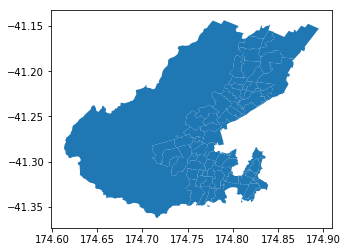

In [15]:
wlg_area_units.plot()

## Wellington street network: without elevation
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

In [16]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

In [17]:
flat_network = aa.get_pandana_network(osm_bbox, impedance=distance)

data/network_-41.38_174.57_-41.1527_174.84.h5


The _pandana_ network above has edge weights in the default units of metres, which means that the accessibility analyses will also be in metres. We can post-hoc convert the distance units to travel time with an average walking speed of 5 km/h or, 83 m/minute if we want travel time in minutes. 

## Wellington street network: with elevation
Elevation information can be retrieved with the Google Elevation API to enrich both the nodes and edges of the network. For the nodes, we can just get the elevation at a single location. Elevation at the connecting nodes of an edge can be used to derive the _inclination_. 

The above steps have been simplified to terse oneliners by the excellent Python package, _osmnx_. The steps to generate a _pandana_ network for accessibility analyses enriched with road inclinations are given below. They're mostly borrowed from [Geoff Boeing's tutorial](https://geoffboeing.com/2017/05/osmnx-street-network-elevation/). 
- [Signing up to the Google Elevation API](https://developers.google.com/maps/documentation/elevation/start) and getting an API key. 
- Storing the API key in an YAML file (to stop commits that contain keys! - something I've been guilty of many times over)
- Creating an _osmnx_ graph
- Retrieving elevation data from Google Elevation API
- Adding elevation information to nodes 
- Adding inclination (grade) to edges
- Converting edge weights to travel time
- Creating a _pandana_ network from an _osmnx_ graph


In [18]:
# Open the API keys stored in a YAML file
with open("utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

# Create an OSMNX walking street netwoek for the Wellington bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# Add elevation values for the nodes in the OSMNX graph
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G = ox.add_edge_grades(G)

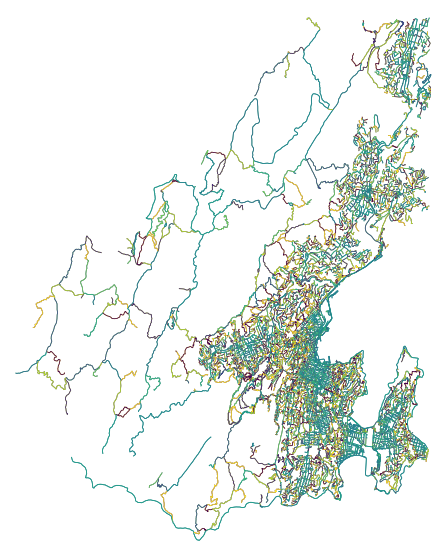

In [19]:
ec = ox.get_edge_colors_by_attr(G, 'grade', cmap='viridis', num_bins=10)
fig, ax = ox.plot_graph(G, fig_height=10, edge_color=ec, edge_linewidth=0.8, node_size=0)

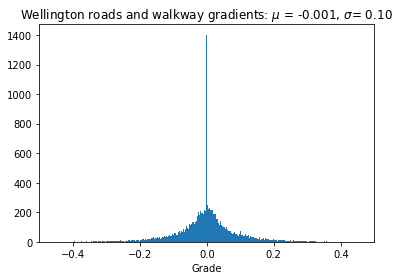

In [20]:
# Extract edge grades from osmnx network object
edge_grades = [data['grade'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]

# Plot distribution of road and walkway gradients in Wellington
plt.hist(edge_grades, bins=1000);
plt.xlim(-0.5,0.5);
plt.xlabel('Grade');
plt.title("Wellington roads and walkway gradients: $\mu$ = {:.3f}, $\sigma$= {:.2f}".format(np.mean(edge_grades), 
                                                                                            np.std(edge_grades)));

# Accessibility analysis using network with street gradients

## Reproducing existing accessibility analysis

In [21]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [22]:
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'

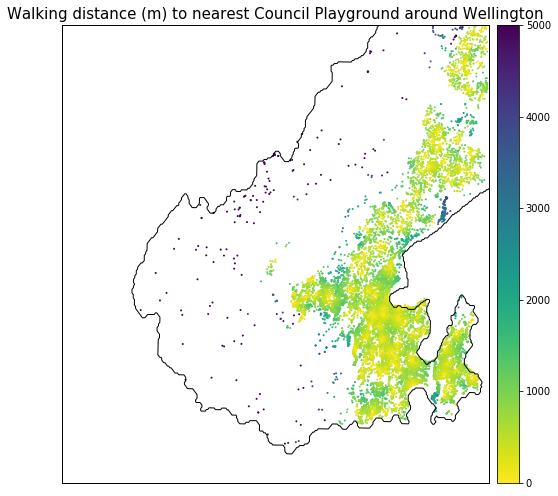

In [23]:
# Create a pandana network with data extracted from an OSMNX graph
flat_distance_network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

# Calculate accessibility
playground_accessibility_flat = aa.get_accessibility(flat_distance_network, 
                                                     wcc_playgrounds, distance=5000, num_pois=10)

# Plot accessibility
aa.plot_accessibility(flat_distance_network, playground_accessibility_flat[1], osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

## Converting distance to travel time

A [simple search](https://books.google.co.nz/books?id=SyulBQAAQBAJ&pg=PA160&lpg=PA160&dq=walking+speed+gradient+accessibility&source=bl&ots=iKmtg73TIV&sig=ACfU3U3N5CAAtqoA0QzfSpJubylfjneWtA&hl=en&sa=X&ved=2ahUKEwiqqeKj3YTgAhVQXn0KHdSFDWsQ6AEwAHoECAkQAQ#v=onepage&q=walking%20speed%20gradient%20accessibility&f=false) led me to [Naismith's Rule](https://en.wikipedia.org/wiki/Naismith%27s_rule) and then to [Tobler's Hiking Function](https://en.wikipedia.org/wiki/Tobler%27s_hiking_function) to calculate travel time as a function of distance and gradient. 

I've chosen to go with Tobler's without too much rationale other than its simple form. Tobler's hiking function for speed, $\nu$, is a shifted exponential with three parameters: $a$, $b$ and $c$ which give the fastest speed, speed retardation due to gradient and shift from zero respectively. 

$$
\nu = a\exp^{\left(-b.|slope~+~c|\right)}
$$

Note that $slope$ here is the dimensionless quantity: $\frac{dh}{dx}$ (or, rise / run). Tobler's function can also be written with slope in degrees ($^{\circ}$). Speed in km/h can be converted to a travel time in minutes with the factor (60/1000). 

While I haven't read Tobler's original paper, a [brief exposition of other equivalent functional forms to Tobler's](https://rpubs.com/chrisbrunsdon/hiking) has been written up by Chris Brunsdon. For a more rigorous analysis, we'll need to refit the form above (or similar) as Brunsdon does for different types of pedestrians. According to NZTA and various other studies, there is significant heterogeneity in walking speed; noth from the route (terrain, incline etc) and also the characteristics of the walker e.g. carrying things, footwear, and demographics. We can likely imagine that a commuter will walk at a very different speed to a father taking his children to the playground during the daytime. Brunsdon's analysis itself shows a very different relationship to Tobler's. 

Function | a | b | c 
--- | --- | --- | ---
Tobler | 6 | 3.5 | 0.05 
Brunsdon | 3.557 | 2.03 | 0.133


In [91]:
# Function parameters
toblers = [6.0, 3.5, 0.05]
brunsdon = [3.557, 2.03, 0.13]

In [146]:
street_grades = np.arange(-0.4, 0.4, 0.001)
travel_time_df = pd.DataFrame({'grade':street_grades})
travel_time_df['distance'] = 100

travel_time_df['toblers'] = u.hiking_time(travel_time_df['grade'], travel_time_df['distance'], params_list=toblers)
travel_time_df['brunsdon'] = u.hiking_time(travel_time_df['grade'], travel_time_df['distance'], params_list=brunsdon)
travel_time_df['flat_5khr'] = u.flat_travel_time(travel_time_df['distance'])
travel_time_df['flat_3khr'] = u.flat_travel_time(travel_time_df['distance'], 3.0)

travel_speed_df = pd.DataFrame({'grade':street_grades})
travel_speed_df['toblers'] = u.hiking_speed(travel_speed_df['grade'], params_list=toblers)
travel_speed_df['brunsdon'] = u.hiking_speed(travel_speed_df['grade'], params_list=brunsdon)

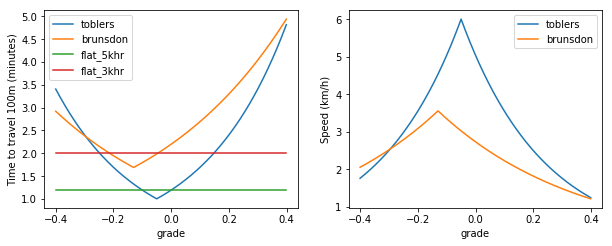

In [147]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(221)
travel_time_df[['toblers', 'brunsdon', 'flat_5khr', 'flat_3khr', 'grade']].plot(x='grade', ax = ax1)
plt.ylabel('Time to travel 100m (minutes)');

ax2 = plt.subplot(222)
travel_speed_df[['toblers', 'brunsdon','grade']].plot(x='grade', ax = ax2)
plt.ylabel('Speed (km/h)');


## Pandana network with travel times

In [79]:
# Get edges dataframe again because multi-indexing is AWKWARD! 
edges_gdfs = graph_df[1]

# Add the travel times 
edges_gdfs['inv_grade'] = - edges_gdfs['grade']
edges_gdfs['time_5khr'] = flat_travel_time(edges_gdfs['length'])
edges_gdfs['time_tobler'] = hiking_time(edges_gdfs['grade'], edges_gdfs['length'])

# Create the expected indices for pandana edges 
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Create pandana network objects for flat and hilly terrain travel times
network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                     edges_gdfs['u'], edges_gdfs['v'], 
                     edges_gdfs[['time_5khr']])

network_hills = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                           edges_gdfs['u'], edges_gdfs['v'], 
                           edges_gdfs[['time_tobler']])

In [80]:
# Calculate accessibility
playground_accessibility = aa.get_accessibility(network, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_accessibility = aa.get_accessibility(network_hills, wcc_playgrounds, distance=30, num_pois=10)

In [242]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
#plot_kwargs = {'s':5, 
#               'alpha':0.9, 
#               'cmap':'viridis_r', 
#               'edgecolor':'none'}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

In [144]:
?network.nearest_pois

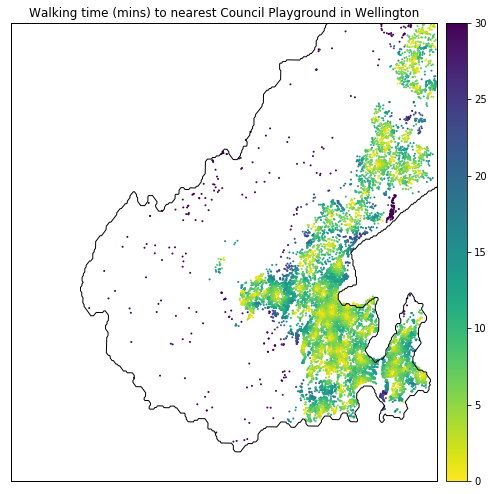

In [83]:
aa.plot_accessibility(network, playground_accessibility[1], osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)
plt.title('Walking time (mins) to nearest Council Playground in Wellington');

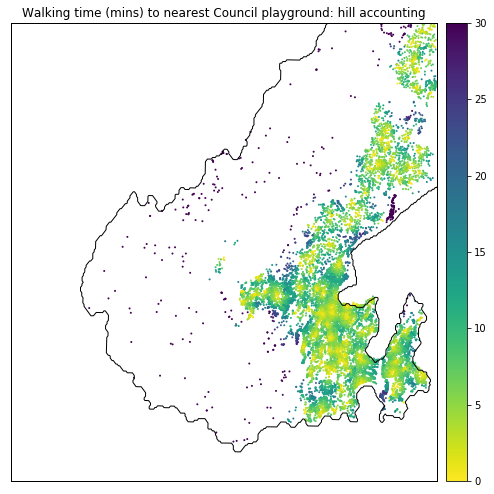

In [81]:
aa.plot_accessibility(network_hills, playground_hills_accessibility[1], osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)
plt.title('Walking time (mins) to nearest Council playground: hill accounting');

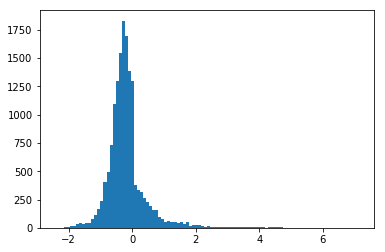

In [87]:
diff_accessibility = playground_hills_accessibility[1] - playground_accessibility[1]
plt.hist(diff_accessibility, bins=100);

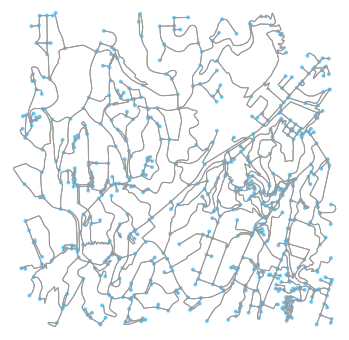

(<Figure size 590.571x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a210ea978>)

In [130]:
G_sub = ox.graph_from_point((-41.2825478, 174.7615090), distance=900, network_type='walk')
ox.plot_graph(G_sub)

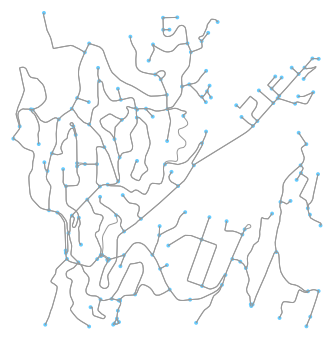

(<Figure size 564.007x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a34ca2470>)

In [82]:
G_sub = ox.graph_from_point((-41.2825478, 174.7615090), distance=900, network_type='drive')
ox.plot_graph(G_sub)

# Validating pandana with Graphhopper Routing API

Visualised [here](https://www.openstreetmap.org/directions?engine=graphhopper_foot&route=-41.28228%2C174.76145%3B-41.28352%2C174.76559#map=17/-41.28247/174.76603)

In [10]:
graph_hopper_api_key = data_loaded['graph_hopper_api_key'][0]
graph_hopper_query = "https://graphhopper.com/api/1/route?point=-41.28228,174.76145&point=-41.28352,174.76559&vehicle=foot&points_encoded=false&locale=nz&key=" + graph_hopper_api_key

In [12]:
%%bash -s "$graph_hopper_query"
curl $1

{"hints":{"visited_nodes.average":"38.0","visited_nodes.sum":"38"},"info":{"copyrights":["GraphHopper","OpenStreetMap contributors"],"took":12},"paths":[{"distance":714.815,"weight":423.840217,"time":514662,"transfers":0,"points_encoded":false,"bbox":[174.761453,-41.283523,174.765629,-41.282102],"points":{"type":"LineString","coordinates":[[174.761453,-41.282274],[174.761556,-41.28231],[174.761589,-41.282407],[174.761905,-41.282449],[174.761958,-41.282571],[174.761933,-41.282646],[174.761754,-41.282885],[174.761788,-41.283035],[174.761917,-41.28316],[174.76219,-41.283275],[174.762386,-41.283379],[174.762797,-41.28334],[174.76299,-41.283305],[174.763289,-41.283009],[174.763493,-41.282658],[174.763737,-41.282442],[174.764054,-41.282246],[174.764241,-41.282201],[174.764536,-41.282165],[174.764845,-41.282102],[174.764858,-41.282178],[174.764869,-41.282245],[174.765038,-41.282236],[174.765055,-41.282515],[174.765029,-41.282649],[174.764967,-41.282802],[174.765087,-41.282817],[174.765072,-41

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2697  100  2697    0     0   1164      0  0:00:02  0:00:02 --:--:--  1164


In [131]:
route = [[174.761453,-41.282274],[174.761556,-41.28231],[174.761589,-41.282407],[174.761905,-41.282449],[174.761958,-41.282571],[174.761933,-41.282646],[174.761754,-41.282885],[174.761788,-41.283035],[174.761917,-41.28316],[174.76219,-41.283275],[174.762386,-41.283379],[174.762797,-41.28334],[174.76299,-41.283305],[174.763289,-41.283009],[174.763493,-41.282658],[174.763737,-41.282442],[174.764054,-41.282246],[174.764241,-41.282201],[174.764536,-41.282165],[174.764845,-41.282102],[174.764858,-41.282178],[174.764869,-41.282245],[174.765038,-41.282236],[174.765055,-41.282515],[174.765029,-41.282649],[174.764967,-41.282802],[174.765087,-41.282817],[174.765072,-41.282912],[174.765298,-41.282989],[174.765114,-41.283073],[174.765338,-41.283153],[174.765307,-41.28321],[174.765302,-41.283272],[174.765344,-41.283328],[174.765628,-41.283451],[174.765629,-41.283497],[174.765594,-41.283523]]

In [134]:
node_i = ox.get_nearest_node(G_sub, (174.761453,-41.282274))
print(node_i)
edges_gdfs.ix[node_i]

783294552


,access,bridge,geometry,grade,grade_abs,highway,junction,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width,time_5khr,time_tobler,inv_grade,time_tobler_inv
,,,,,,,,,,,,,,,,,,,,,,,,,
783294557,NaN,NaN,"LINESTRING (174.7520745 -41.2746057, 174.75203...",0.0802,0.0802,service,NaN,0,NaN,NaN,56.102,NaN,NaN,False,62992892,NaN,NaN,NaN,783294552,783294557,NaN,0.673224,0.884884,-0.0802,0.623567
783294550,NaN,NaN,"LINESTRING (174.7520745 -41.2746057, 174.75257...",-0.0615,0.0615,service,NaN,0,NaN,NaN,42.178,NaN,NaN,False,62992940,NaN,NaN,NaN,783294552,783294550,NaN,0.506136,0.439103,0.0615,0.623117
783294607,NaN,NaN,"LINESTRING (174.7520745 -41.2746057, 174.75198...",-0.0609,0.0609,service,NaN,0,NaN,NaN,50.405,NaN,NaN,False,62992892,NaN,NaN,NaN,783294552,783294607,NaN,0.604860,0.523651,0.0609,0.743096


In [143]:
?ox.get_nearest_nodes

# Accessibility by Wellington suburb

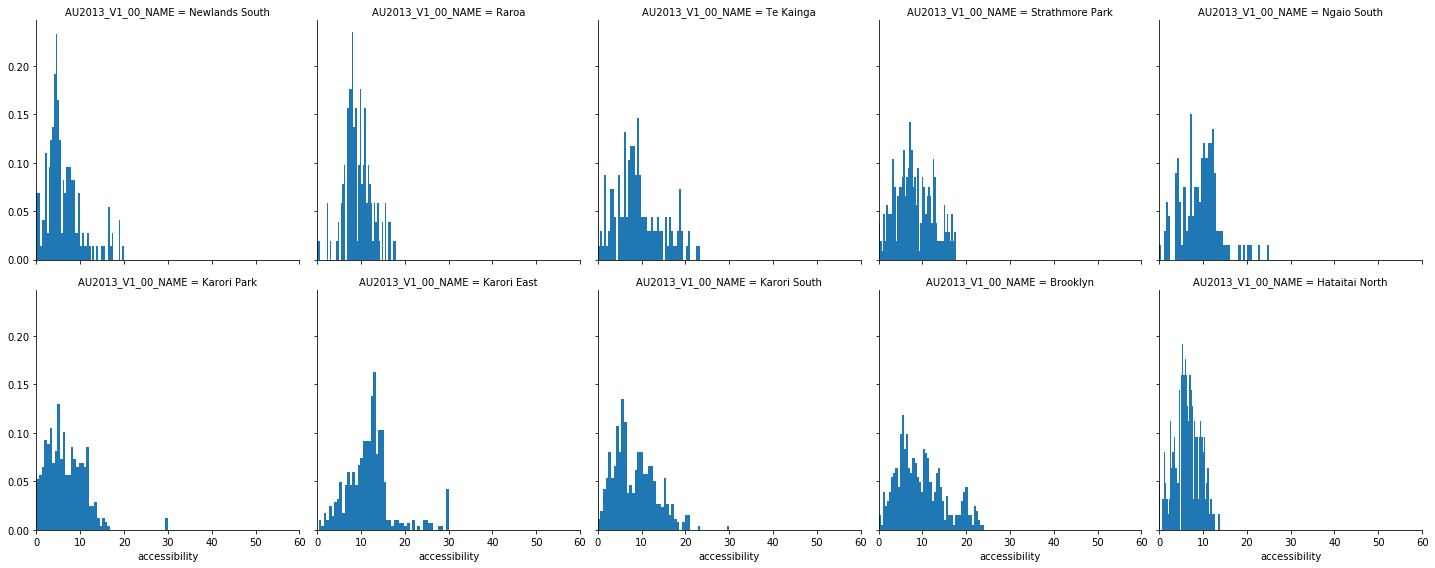

In [82]:
# Get lat and lon coordinates for accessibility values
orig_nodes = network_hills.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), playground_hills_accessibility[[1]].reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']
# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})


playground_df = geopandas.sjoin(wlg_area_units, df_joined_coords, op='contains')
df_sel = playground_df[playground_df['AU2013_V1_00_NAME'].isin(['Karori Park', 'Te Kainga',
                                          'Karori South', 'Karori East',
                                         'Newlands South', 'Hataitai North', 
                                          'Strathmore Park', 'Raroa',
                                         'Ngaio South', 'Brooklyn'])]
g = sns.FacetGrid(col='AU2013_V1_00_NAME', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
plt.xlim(0,60);
#plt.ylim(0, 0.0035);